# Data Description

Daily historical sales data of 60 shops in Russia.

# Objective

Forecast the next month's daily sales for each shop, and provide an easy and practical way to present the results via Telegram.

# Section 1 - Time Series with LSTM

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats

from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()

from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras

from keras.models import model_from_json

## Loading Data

link dos datasets do kagle

https://www.kaggle.com/c/competitive-data-science-predict-future-sales

In [2]:
sales_train = pd.read_csv('sales_train.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv')

sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

## Data Preparation and EDA

In [3]:
print('Amount of shops: '+f'{len(shops.shop_id.unique())}')
print('Amount of items: '+f'{len(items.item_id.unique())}')
print('Amount of categories: '+f'{len(item_categories.item_category_id.unique())}')
print('Amount of cnt_day: '+f'{len(sales_train.item_cnt_day.unique())}')
print('Amount of months: '+f'{max(sales_train.date_block_num)}')

Amount of shops: 60
Amount of items: 22170
Amount of categories: 84
Amount of cnt_day: 198
Amount of months: 33


In [4]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
# Mudando a coluna "date" para tipo data
sales_train.date = pd.to_datetime(sales_train.date, dayfirst=True)

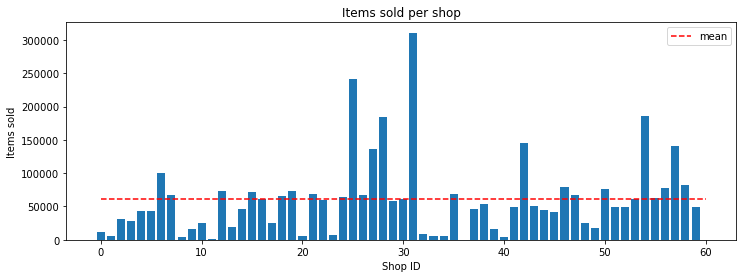

In [7]:
total_items_sold = sales_train.groupby(['shop_id'])['item_cnt_day'].sum()
fig = plt.figure(figsize=(12,4))
plt.bar(total_items_sold.index,total_items_sold)
plt.title('Items sold per shop')
plt.xlabel('Shop ID')
plt.ylabel("Items sold")
plt.hlines(total_items_sold.mean(),0,60,color='r',linestyle='dashed',label = 'mean')
plt.legend()

plt.show()

In [8]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

In [9]:
df = sales_train.groupby(['date','shop_id']).agg({'item_cnt_day':'sum'}).reset_index()
df.head()

date  shop_id  item_cnt_day
0 2013-01-01        2          24.0
1 2013-01-01        7          89.0
2 2013-01-01        8          50.0
3 2013-01-01       13          31.0
4 2013-01-01       14          66.0

In [10]:
df1 = pd.pivot_table(sales_train,values='item_cnt_day',index='date',columns='shop_id',aggfunc='sum')
df1.head()

shop_id        0      1     2     3      4   5      6      7      8   9   ...  \
date                                                                      ...   
2013-01-01    NaN    NaN  24.0   NaN    NaN NaN    NaN   89.0   50.0 NaN  ...   
2013-01-02    NaN    NaN  76.0  64.0  166.0 NaN  173.0  208.0  138.0 NaN  ...   
2013-01-03  203.0  204.0  96.0  43.0  142.0 NaN  187.0  158.0  121.0 NaN  ...   
2013-01-04  352.0   39.0  80.0  44.0  132.0 NaN  187.0  117.0  106.0 NaN  ...   
2013-01-05  292.0  200.0  72.0  29.0  116.0 NaN  144.0  125.0   99.0 NaN  ...   

shop_id        50     51     52     53     54  55     56  57  58     59  
date                                                                     
2013-01-01    NaN  136.0    NaN    NaN  415.0 NaN    NaN NaN NaN    NaN  
2013-01-02  231.0  147.0  119.0  149.0  709.0 NaN  375.0 NaN NaN  155.0  
2013-01-03  236.0  146.0  100.0  116.0  586.0 NaN  244.0 NaN NaN  158.0  
2013-01-04  206.0  121.0  115.0  104.0  495.0 NaN  171.0 NaN NaN   92.0  
2013-01-05  155.0   88.0   62.0  141.0  495.0 NaN  191.0 NaN NaN  101.0  

[5 rows x 60 columns]

Testando estacionariedade:

In [11]:
data_train = pd.DataFrame(df1.iloc[:,2])
result = adfuller(data_train.fillna(0).values)
print('ADF Statistic: ' + str(result[0]))
print('p-value: ' + str(result[1]))
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]['5%']:
    print('Reject Ho - Time Series is Sationary')
else:
    print('Failed to Reject - Time Series is not Stationary')

ADF Statistic: -5.947830964426171
p-value: 2.182797472314011e-07
Critical Values: 
	1%: -3.437
	5%: -2.864
	10%: -2.568
Reject Ho - Time Series is Sationary


Resultado de estacionariedade para a loja de id 2. As outras lojas possuem a mesma característica.

In [12]:
results = seasonal_decompose(df1.iloc[:,2][365*2:].fillna(0))

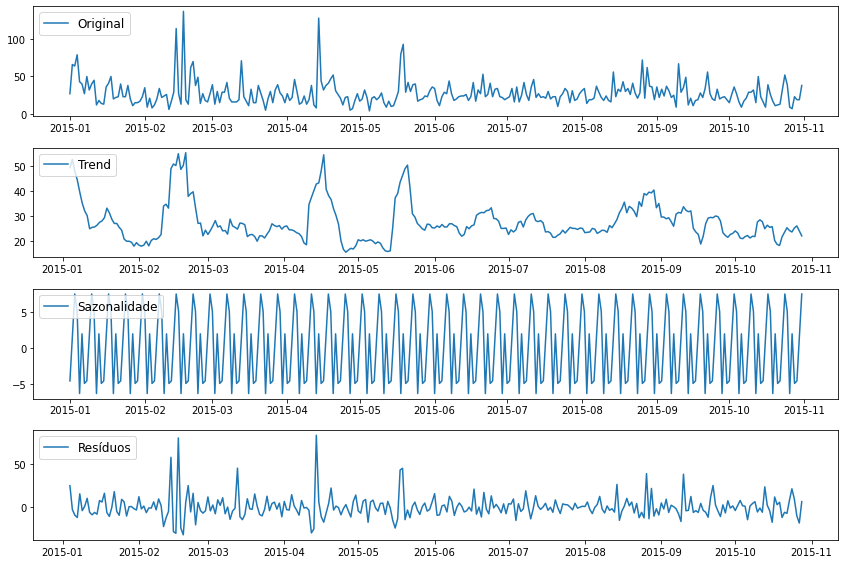

In [13]:
fig, ax = plt.subplots(figsize=(12,8), nrows=4, ncols=1)
plt.tight_layout()
ax[0].plot(df1.iloc[:,2][365*2:],label='Original')
ax[0].legend(loc=2,fontsize=12)
ax[1].plot(results.trend,label='Trend')
ax[1].legend(loc=2,fontsize=12)
ax[2].plot(results.seasonal,label='Sazonalidade')
ax[2].legend(loc=2,fontsize=12)
ax[3].plot(results.resid,label='Resíduos')
ax[3].legend(loc=2,fontsize=12)
plt.show()

O resultado acima é de apenas uma loja, mas se replica às demais. Podemos observar uma sazonalidade semanal.

# Model Training

In [14]:
df2 = df1.replace(-1,0)[365*2:]
#############################
for n in range(60):
    threshold_inf = np.nan_to_num(np.mean(df2[n]) - 3 * np.std(df2[n]))
    threshold_sup = np.nan_to_num(np.mean(df2[n]) + 3 * np.std(df2[n]))
    df2[n].mask(df2[n] < threshold_inf, int(threshold_inf), inplace=True)
    df2[n].mask(df2[n] > threshold_sup, int(threshold_sup), inplace=True)
#############################
scaled_df2 = pd.DataFrame(scaler.fit_transform(df2.fillna(0).values))
scaled_train = scaled_df2.iloc[:-60]
scaled_test = scaled_df2.iloc[-60:]


train = df2.iloc[:-60]
test = df2.iloc[-60:]

In [15]:
n_input = 7 # Sazonalidade semanal
n_features = 1 # Serie temporal unidimensional

##### Ideia: construir um único modelo para prever todas as lojas

pre-processamento

    .Juntar dados das lojas para obter base única para treinamento
    .Tirar lojas com muita correlação para acelerar o treinamento

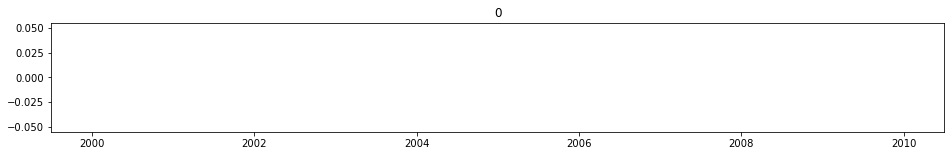

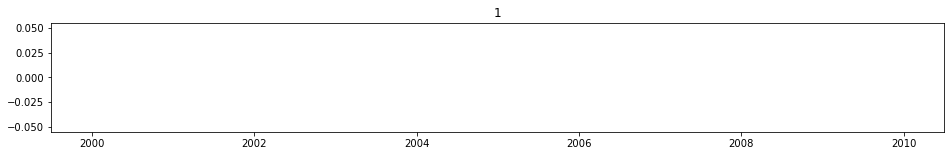

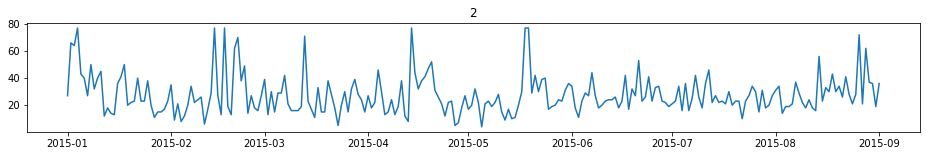

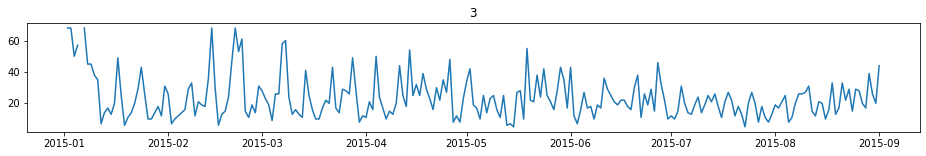

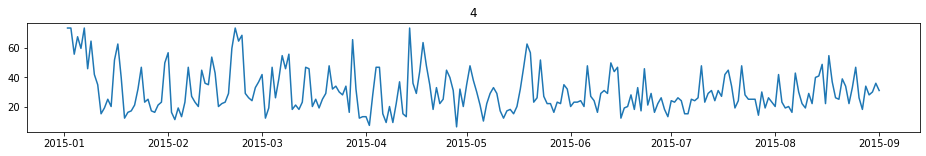

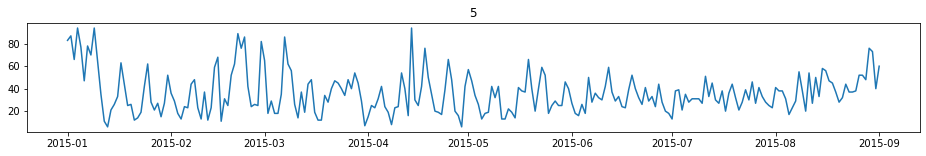

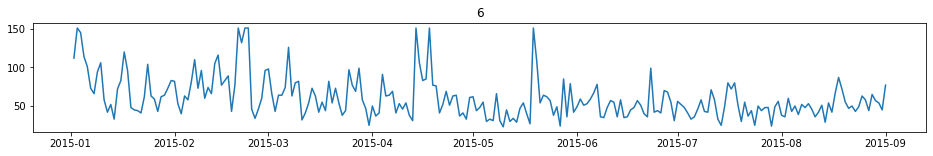

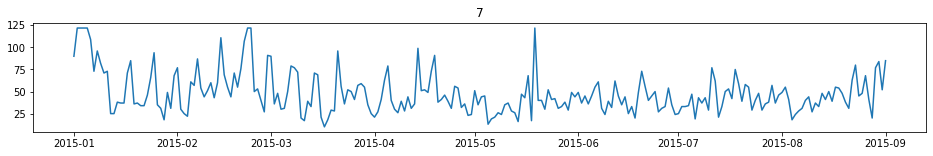

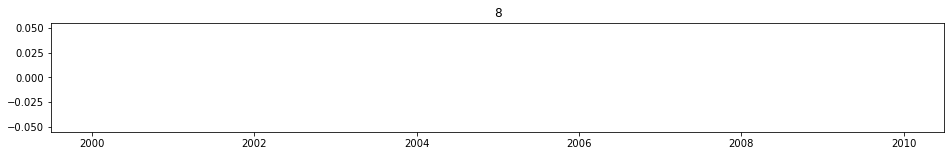

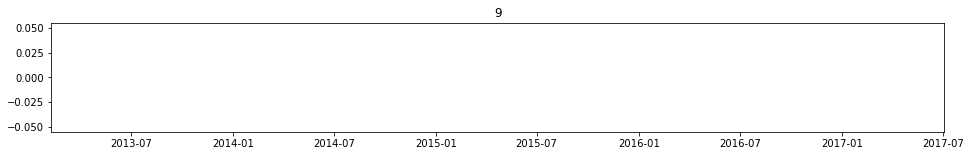

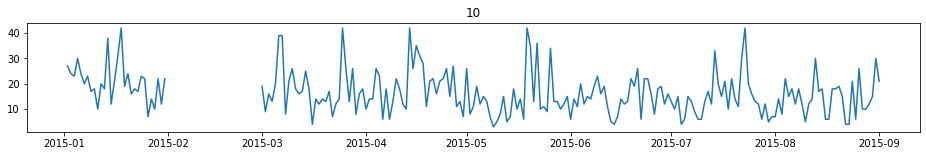

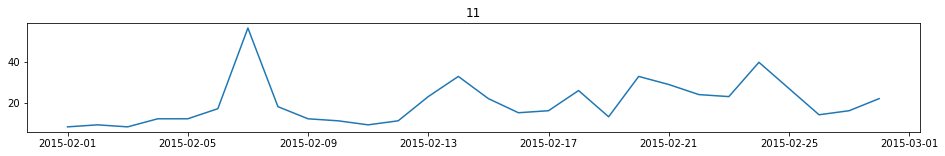

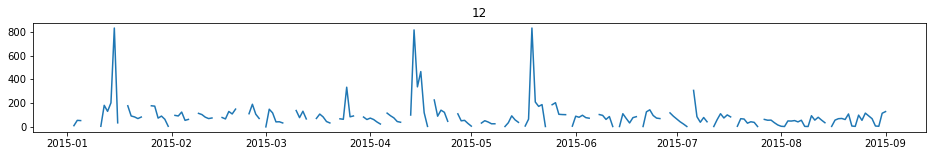

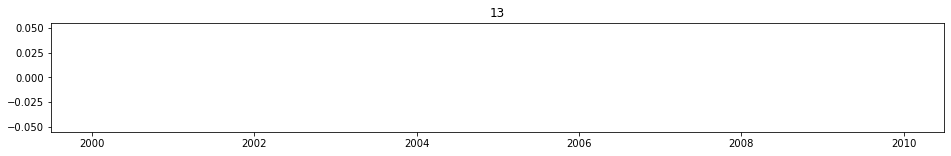

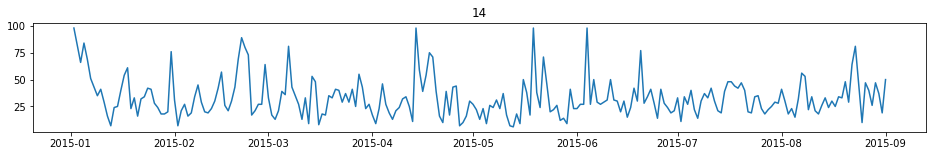

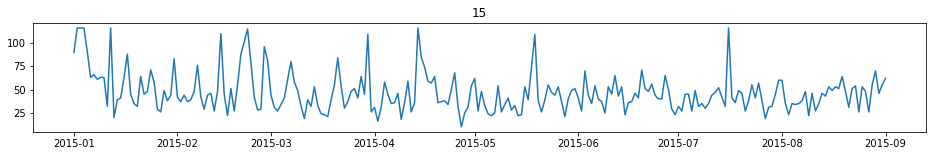

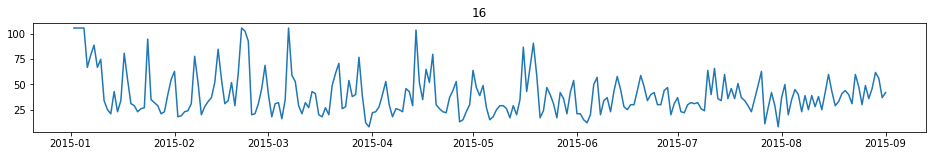

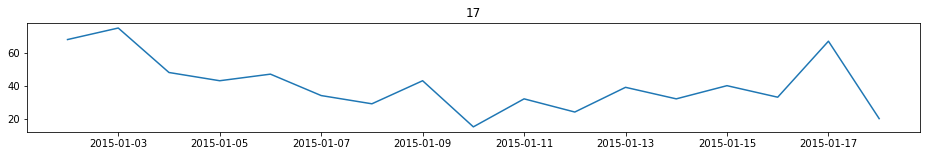

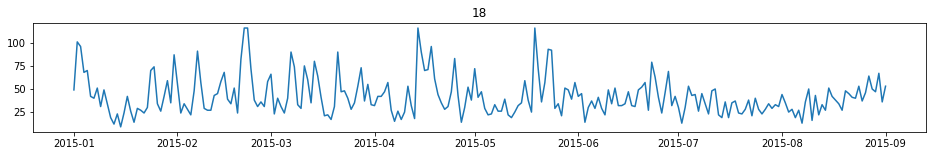

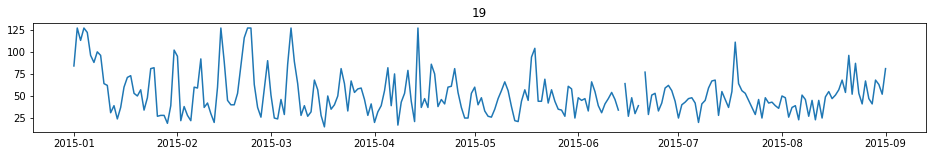

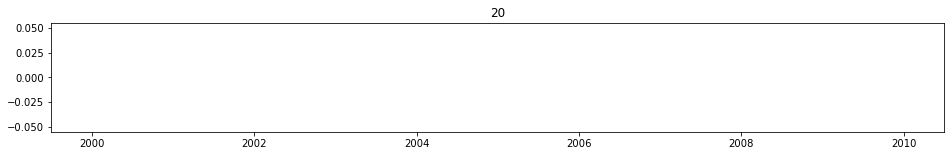

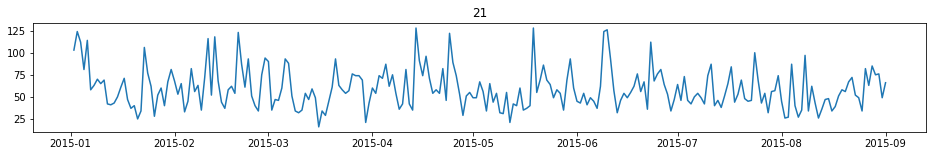

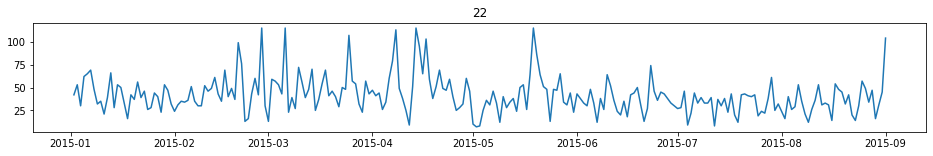

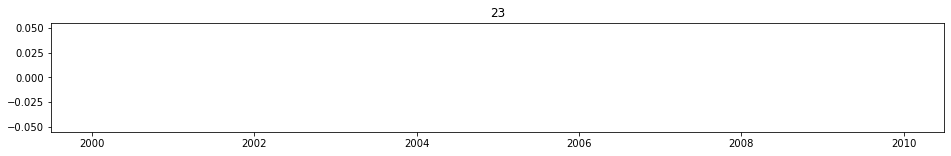

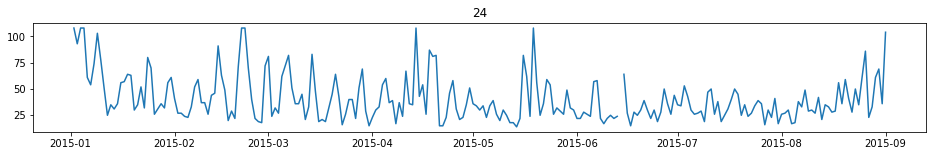

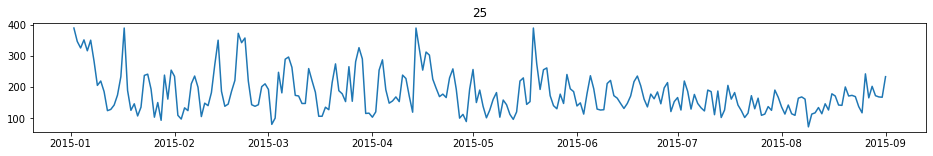

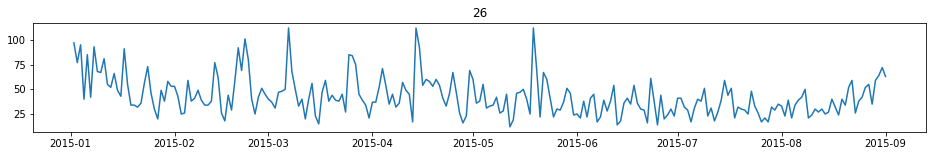

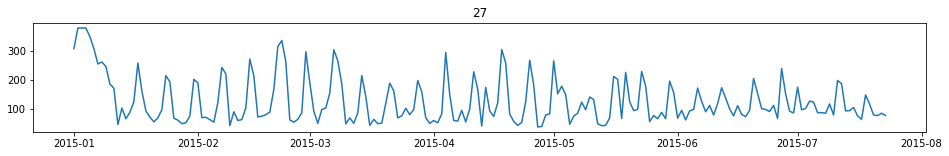

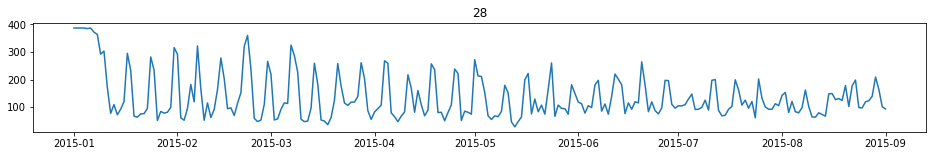

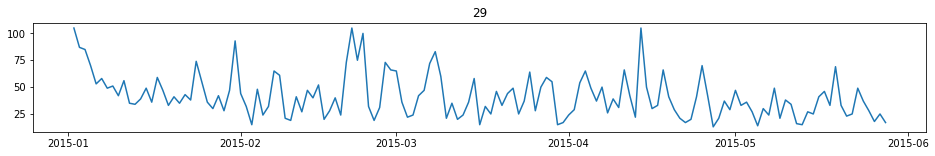

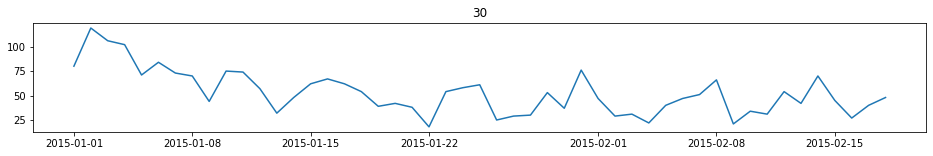

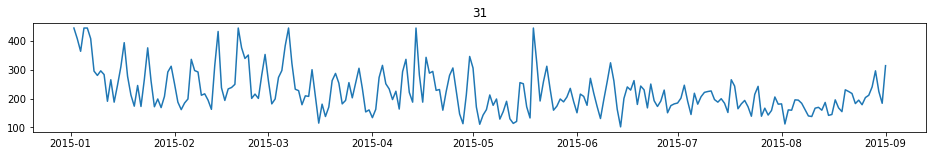

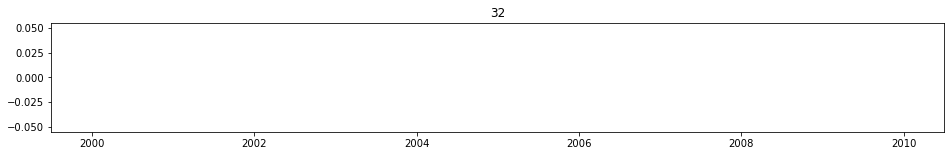

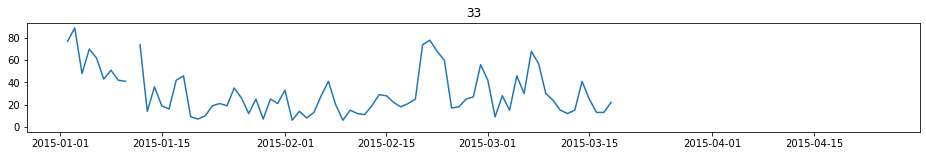

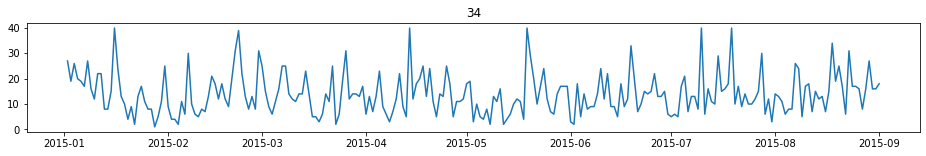

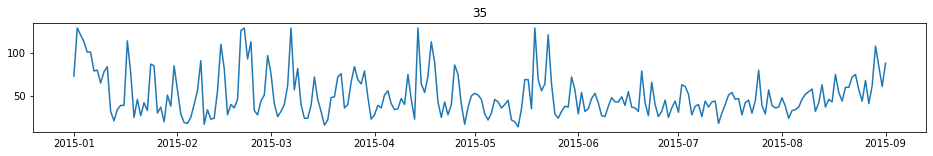

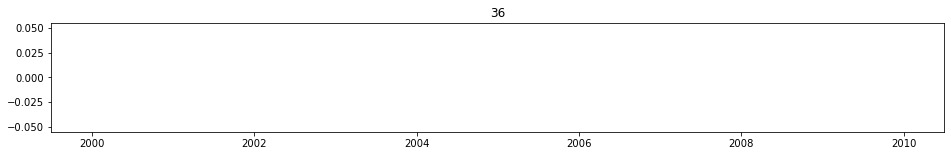

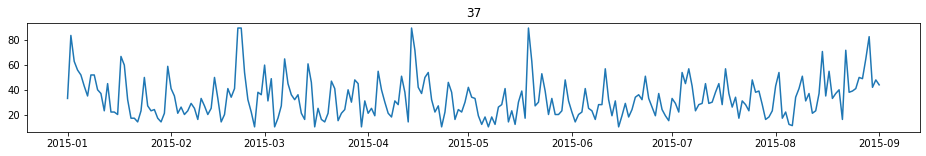

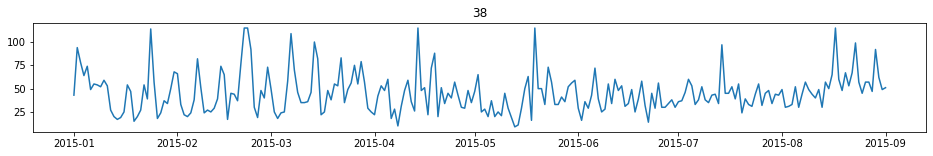

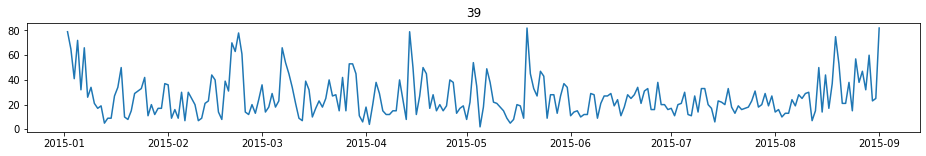

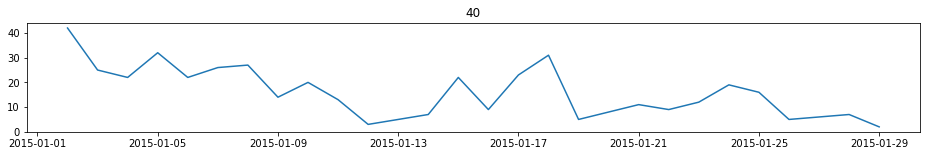

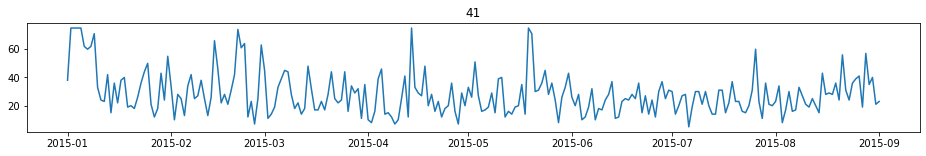

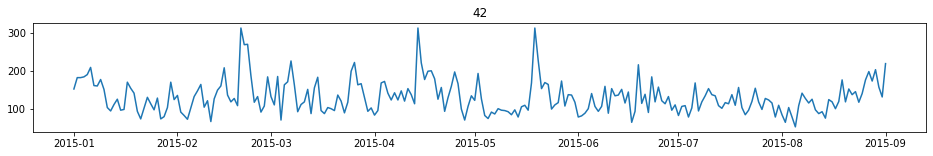

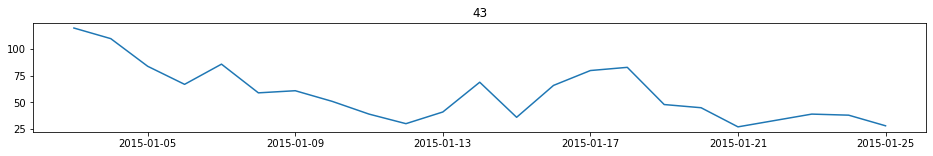

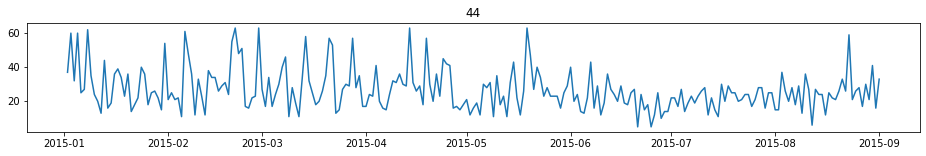

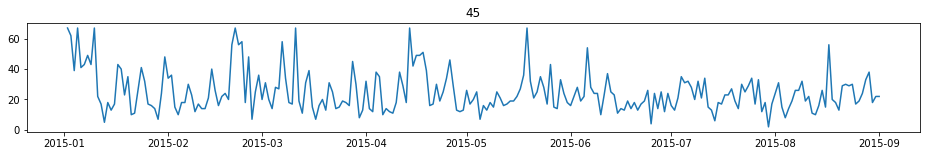

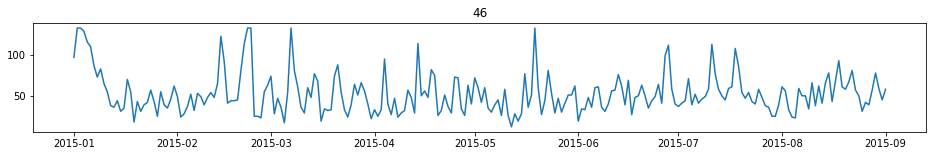

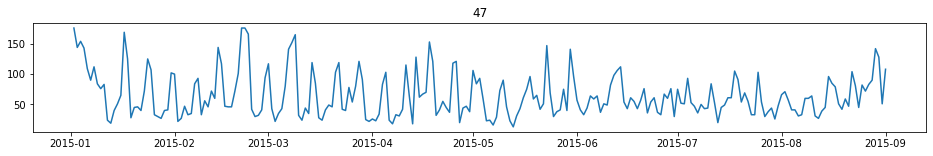

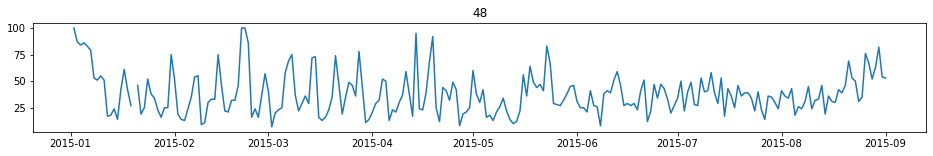

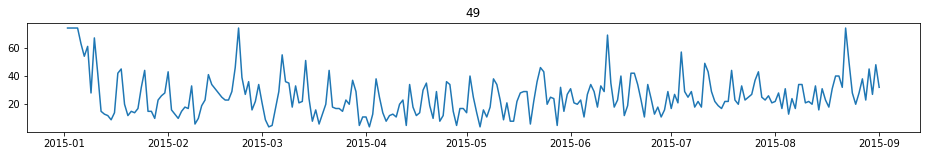

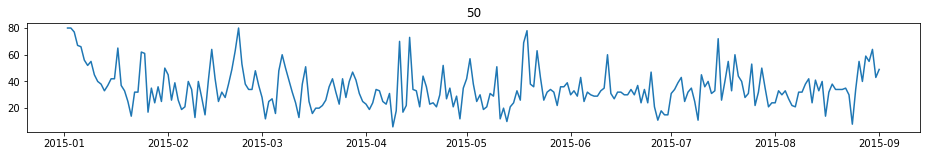

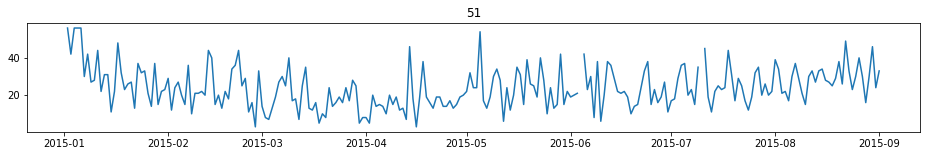

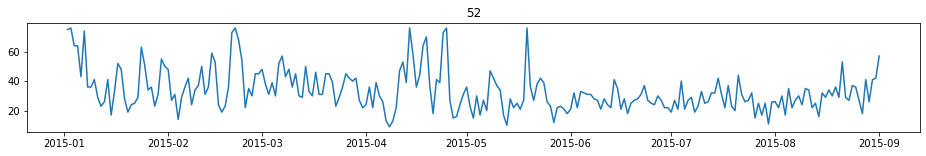

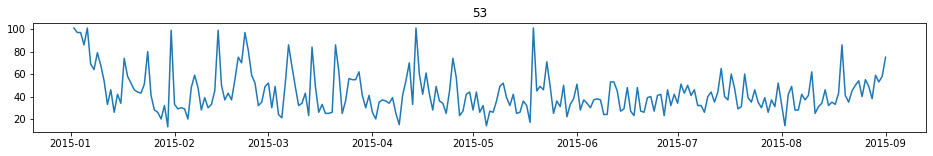

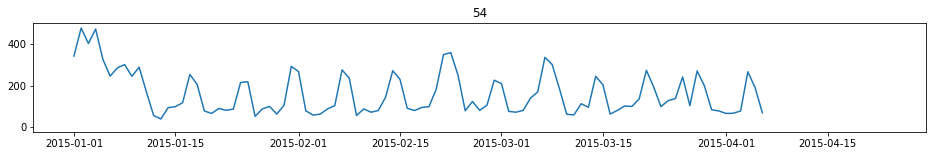

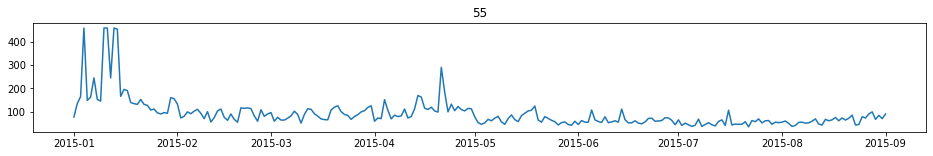

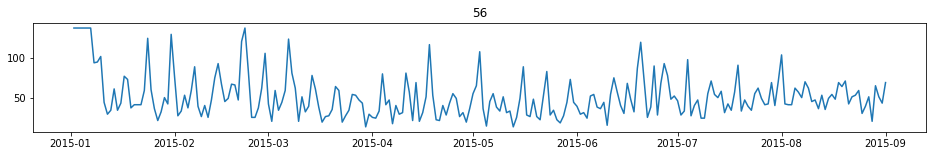

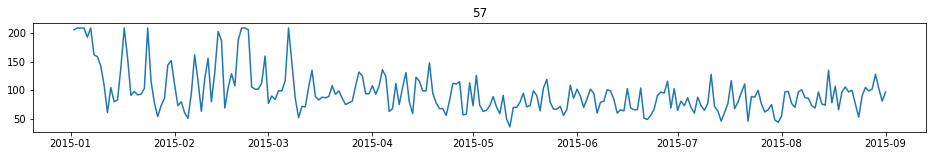

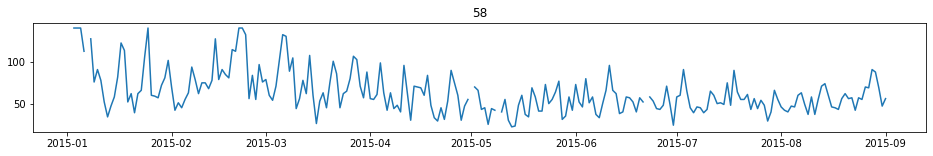

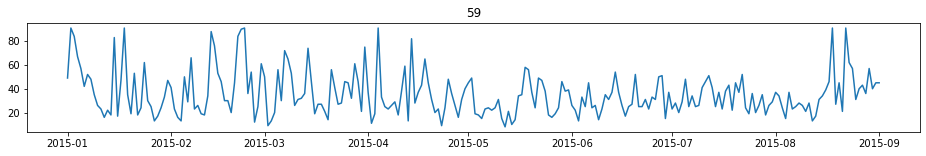

In [696]:
for n in range(60):
    plt.figure(figsize=(16,2))
    plt.plot(train[n])
    plt.title(n)
    plt.show()

In [16]:
# Colunas escolhidas para treinamento
small_scaled_train = scaled_train[[0,1,5,21,34,41,59]]

Juntando os dados

In [17]:
x_train = []
y_train = []
n_shops = len(small_scaled_train.columns)
for s in small_scaled_train.columns:
    shop = small_scaled_train[s].tolist()
    for i in range(n_input,len(shop)):
        x_train.append(shop[i-n_input: i])
        y_train.append(shop[i])
        
size = (len(small_scaled_train)-n_input)*n_shops
x_train = np.array(x_train).reshape(size,n_input,n_features)
y_train = np.array(y_train).reshape(size,)


Modelo LSTM com 1 camada de 100 células e outra de 50, ambas com Função de Ativação ReLu:

In [648]:
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(100,activation = 'relu',input_shape=(n_input,n_features),batch_size=1,return_sequences = True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [649]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 7, 100)               40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
dense (Dense)                (1, 1)                    51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [650]:
# Treinando o modelo (+-1h45min)
model.fit(x_train,y_train,epochs=800,batch_size=1,shuffle=False)

Epoch 1/700
1659/1659 [==============================] - 5s 3ms/step - loss: 0.0293
Epoch 2/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0303
Epoch 3/700
1659/1659 [==============================] - 6s 4ms/step - loss: 0.0301
Epoch 4/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0295
Epoch 5/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0285
Epoch 6/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0275
Epoch 7/700
1659/1659 [==============================] - 7s 5ms/step - loss: 0.0263
Epoch 8/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0256
Epoch 9/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0253
Epoch 10/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0250
Epoch 11/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0249
Epoch 12/700
1659/1659 [==============================] - 8s 5ms/step - lo

1659/1659 [==============================] - 16s 9ms/step - loss: 0.0056
Epoch 191/700
1659/1659 [==============================] - 14s 9ms/step - loss: 0.0074
Epoch 192/700
1659/1659 [==============================] - 14s 8ms/step - loss: 0.0064
Epoch 193/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0065
Epoch 194/700
1659/1659 [==============================] - 12s 7ms/step - loss: 0.0061
Epoch 195/700
1659/1659 [==============================] - 13s 8ms/step - loss: 0.0058
Epoch 196/700
1659/1659 [==============================] - 10s 6ms/step - loss: 0.0060
Epoch 197/700
1659/1659 [==============================] - 10s 6ms/step - loss: 0.0056
Epoch 198/700
1659/1659 [==============================] - 9s 6ms/step - loss: 0.0059
Epoch 199/700
1659/1659 [==============================] - 9s 6ms/step - loss: 0.0069
Epoch 200/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0057
Epoch 201/700
1659/1659 [==============================] - 9s

1659/1659 [==============================] - 6s 4ms/step - loss: 0.0018
Epoch 380/700
1659/1659 [==============================] - 6s 4ms/step - loss: 0.0013
Epoch 381/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0013
Epoch 382/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0012
Epoch 383/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0015
Epoch 384/700
1659/1659 [==============================] - 6s 4ms/step - loss: 0.0013
Epoch 385/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0018
Epoch 386/700
1659/1659 [==============================] - 9s 6ms/step - loss: 0.0015
Epoch 387/700
1659/1659 [==============================] - 20s 12ms/step - loss: 0.0012 0s - loss: 
Epoch 388/700
1659/1659 [==============================] - 10s 6ms/step - loss: 0.0014
Epoch 389/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0015
Epoch 390/700
1659/1659 [============================

1659/1659 [==============================] - 7s 4ms/step - loss: 0.0010
Epoch 474/700
1659/1659 [==============================] - 6s 4ms/step - loss: 9.0163e-04
Epoch 475/700
1659/1659 [==============================] - 7s 4ms/step - loss: 7.3622e-04
Epoch 476/700
1659/1659 [==============================] - 9s 6ms/step - loss: 9.3619e-04
Epoch 477/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0011
Epoch 478/700
1659/1659 [==============================] - 9s 5ms/step - loss: 8.7241e-04
Epoch 479/700
1659/1659 [==============================] - 8s 5ms/step - loss: 0.0016
Epoch 480/700
1659/1659 [==============================] - 7s 5ms/step - loss: 9.0870e-04
Epoch 481/700
1659/1659 [==============================] - 7s 4ms/step - loss: 8.7867e-04
Epoch 482/700
1659/1659 [==============================] - 7s 4ms/step - loss: 0.0012
Epoch 483/700
1659/1659 [==============================] - 6s 4ms/step - loss: 8.0983e-04
Epoch 484/700
1659/1659 [===============

1659/1659 [==============================] - 8s 5ms/step - loss: 5.0196e-04
Epoch 656/700
1659/1659 [==============================] - 8s 5ms/step - loss: 6.3766e-04
Epoch 657/700
1659/1659 [==============================] - 8s 5ms/step - loss: 8.2483e-04
Epoch 658/700
1659/1659 [==============================] - 8s 5ms/step - loss: 7.6806e-04
Epoch 659/700
1659/1659 [==============================] - 9s 6ms/step - loss: 6.8949e-04
Epoch 660/700
1659/1659 [==============================] - 8s 5ms/step - loss: 5.3655e-04
Epoch 661/700
1659/1659 [==============================] - 8s 5ms/step - loss: 5.7737e-04
Epoch 662/700
1659/1659 [==============================] - 8s 5ms/step - loss: 5.6271e-04
Epoch 663/700
1659/1659 [==============================] - 8s 5ms/step - loss: 8.4593e-04
Epoch 664/700
1659/1659 [==============================] - 8s 5ms/step - loss: 6.8092e-04
Epoch 665/700
1659/1659 [==============================] - 8s 5ms/step - loss: 6.2178e-04
Epoch 666/700
1659/1659 

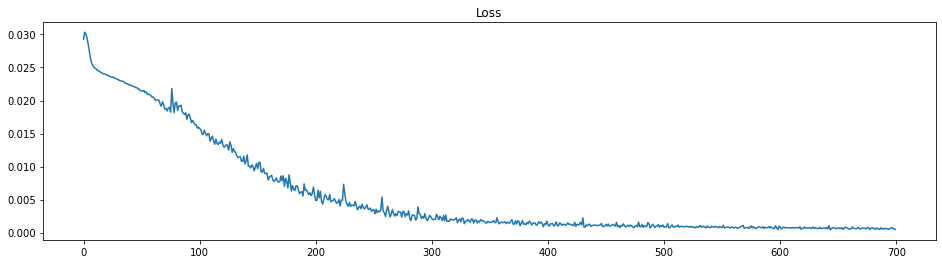

In [651]:
l = model.history.history['loss']
m = np.array(l)[(np.array(l)<0.001)]
plt.figure(figsize=(16,4))
plt.plot(l)
plt.title('Loss')
plt.show()

In [18]:
# Função para prever os dados e voltar para o escala normal
def prediction(model):
    test_predictions = pd.DataFrame()

    for s in range(len(train.columns)):
        shop = scaled_train[s]
            
        first_eval_batch = np.array(shop[-n_input:])
        current_batch = first_eval_batch.reshape(1,n_input,n_features)
        predictions = []
        for i in range(len(test)):

            current_pred = model.predict(current_batch)[0]

            predictions.append(current_pred)

            current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

        test_predictions[s] = predictions

    true_predictions = pd.DataFrame(scaler.inverse_transform(test_predictions))

    true_predictions[true_predictions<0]=0
    true_predictions.index=test.index
    true_predictions = true_predictions.astype('int64')
    return true_predictions

In [652]:
# salvando o modelo
filename = 'ModeloLSTM'
path = 'model\\{}.json'.format(filename)
path_w = 'model\\{}.h5'.format(filename)
model_json = model.to_json()
with open(path, 'w') as file:
    file.write(model_json)
    
model.save_weights(path_w)

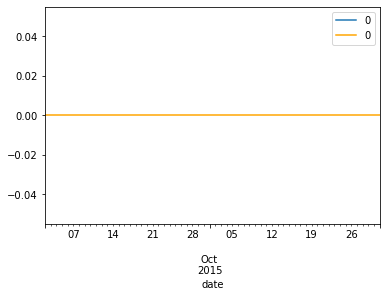

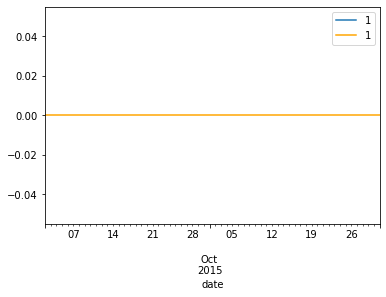

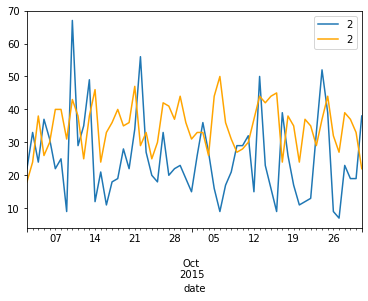

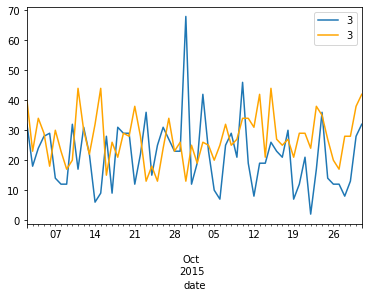

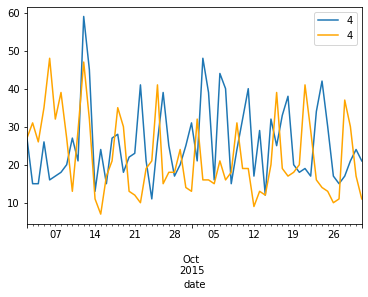

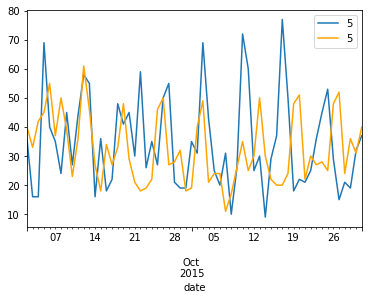

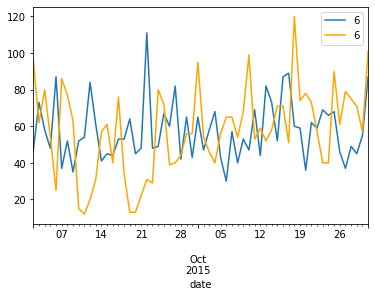

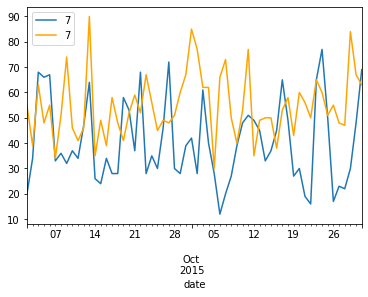

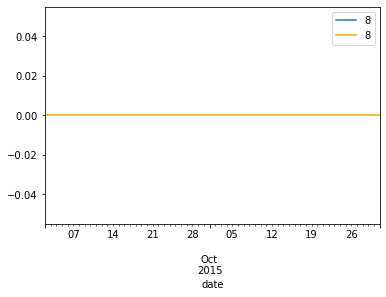

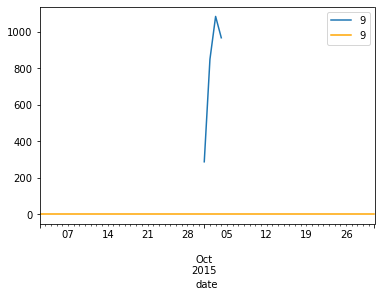

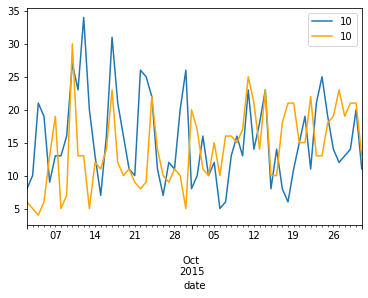

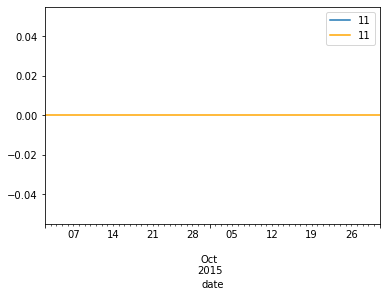

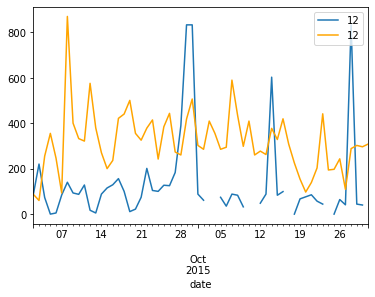

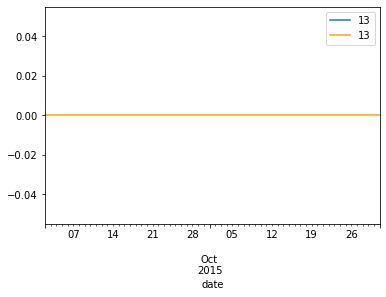

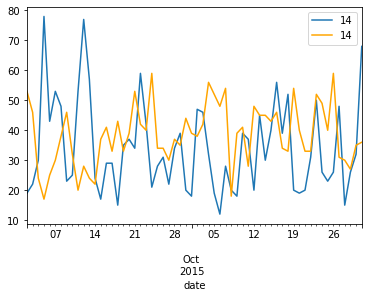

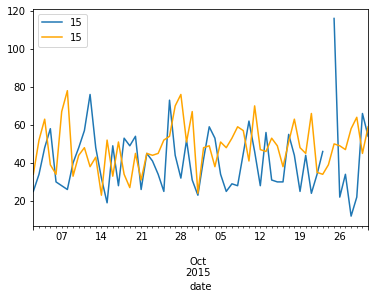

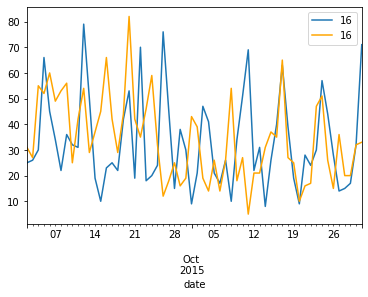

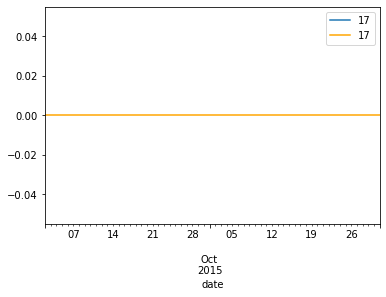

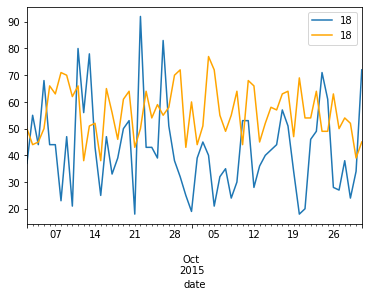

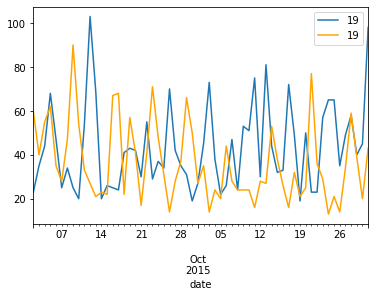

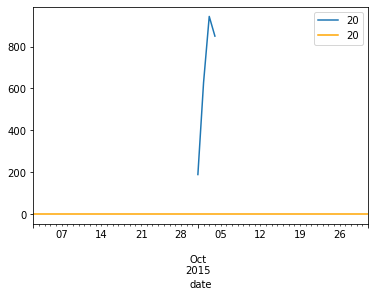

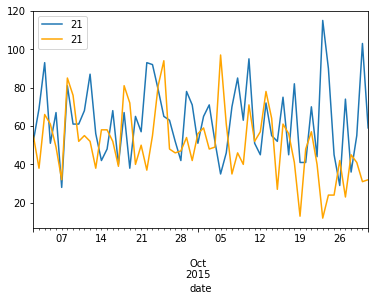

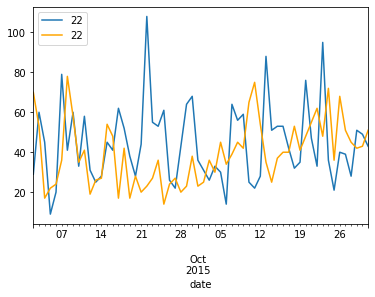

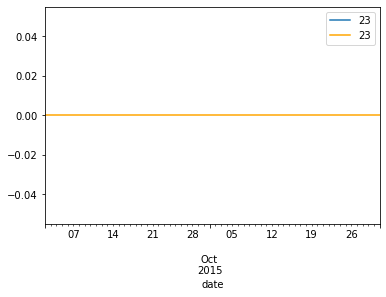

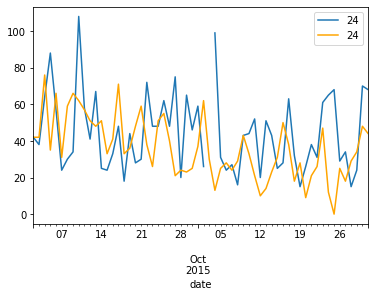

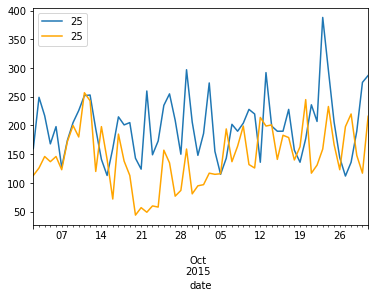

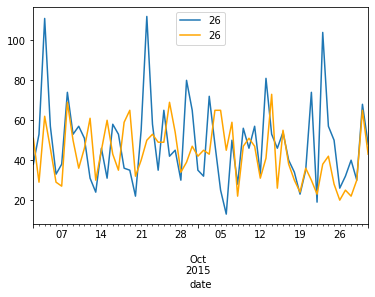

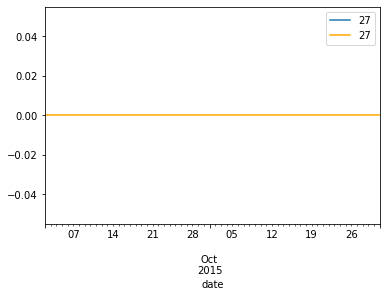

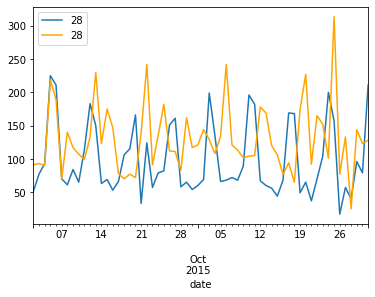

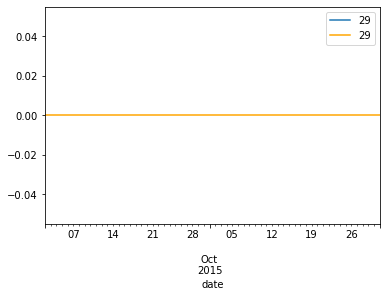

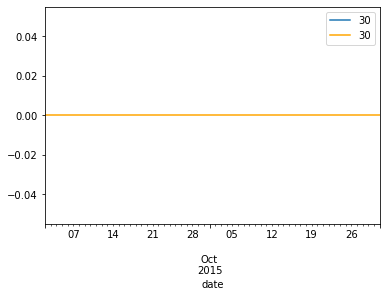

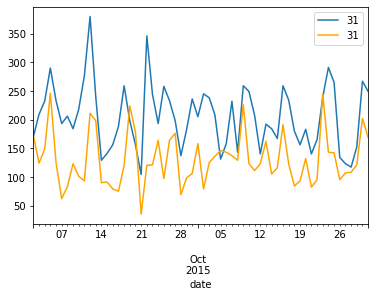

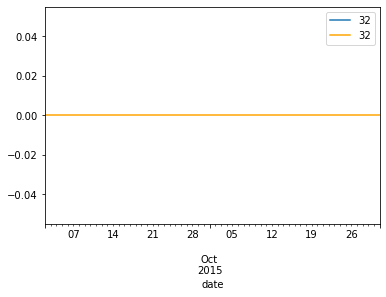

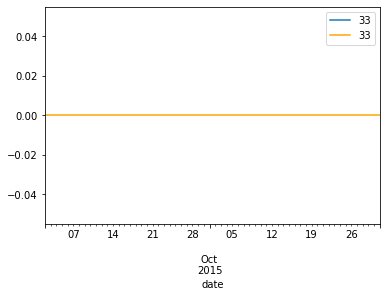

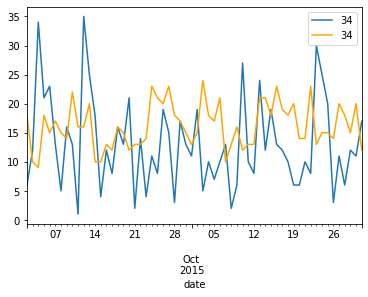

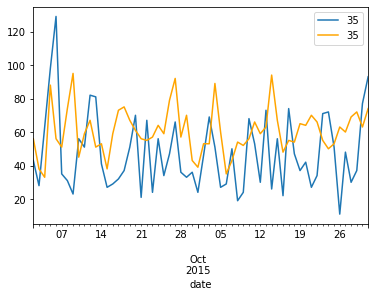

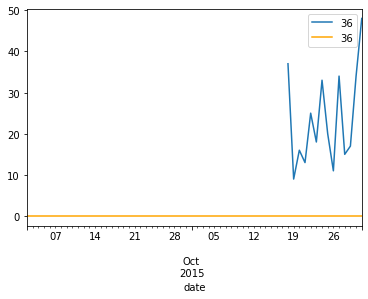

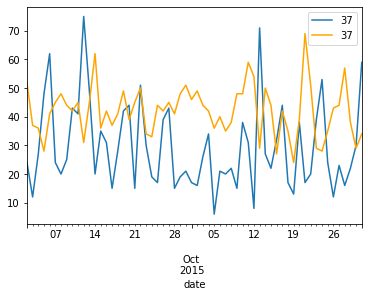

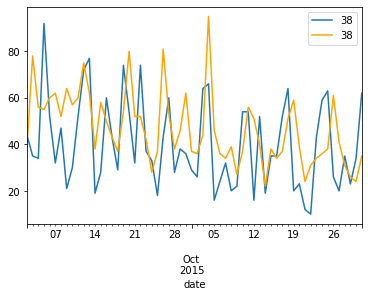

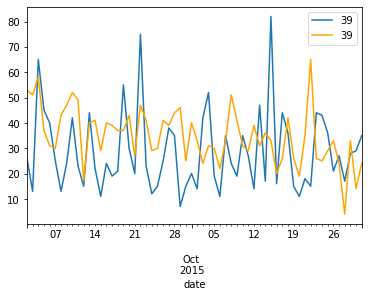

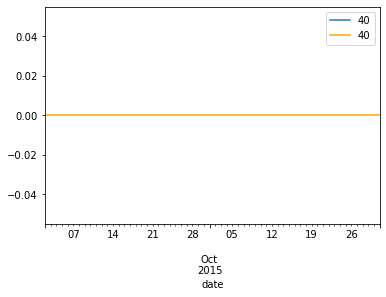

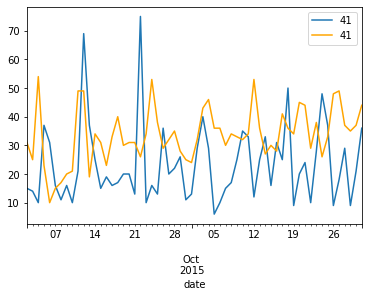

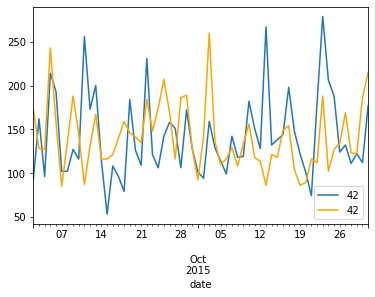

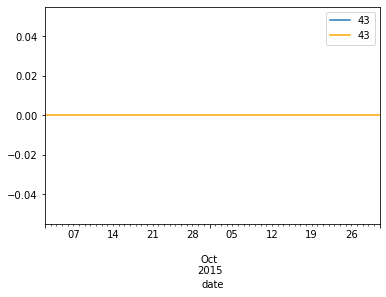

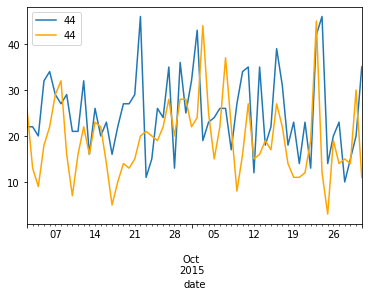

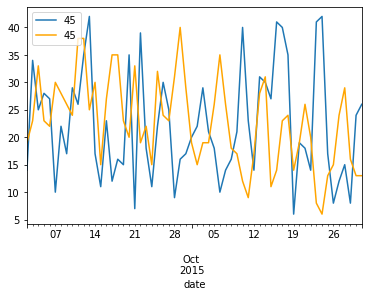

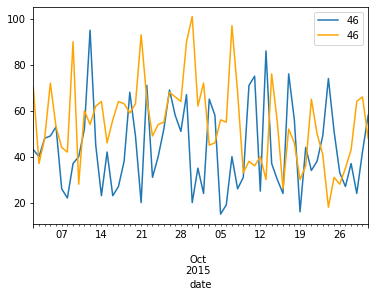

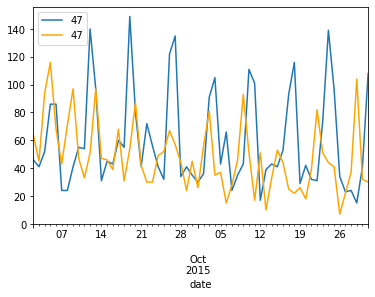

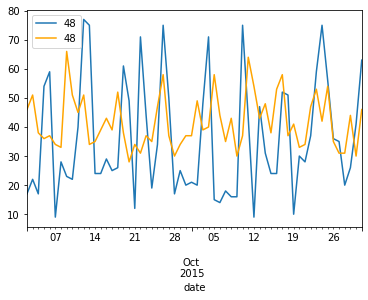

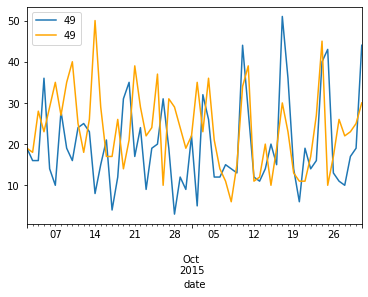

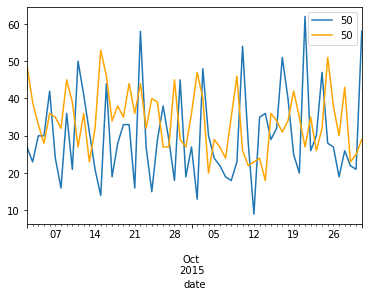

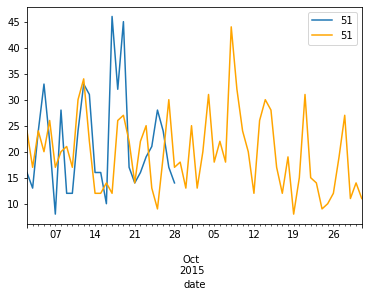

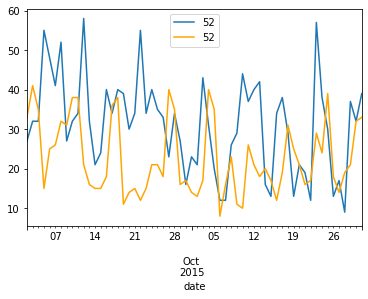

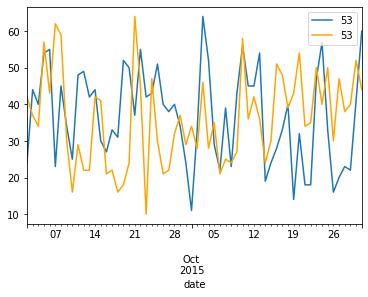

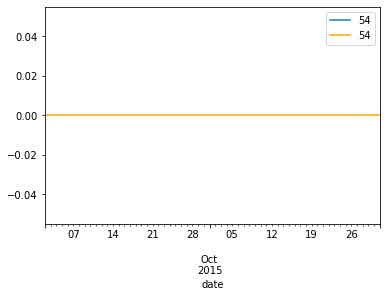

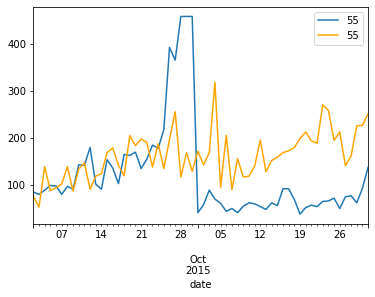

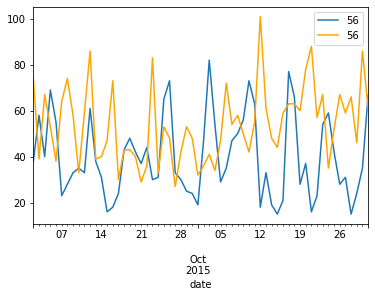

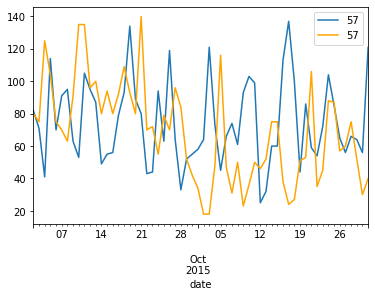

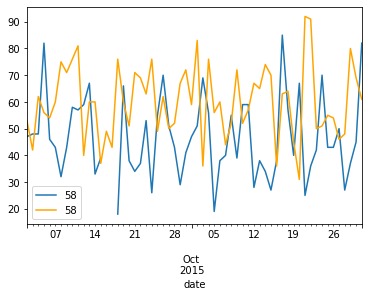

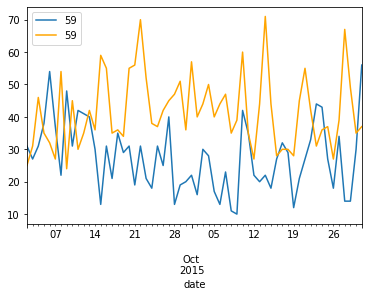

In [654]:
#removendo outliers e fazendo escala em todo dataset
#[0,1,5,21,34,41,59]
# n_input = 7
#LSTM=100 relu
#LSTM=50 relu
#epoch=800
filename = 'modeloLSTM'
path = 'model\\{}.json'.format(filename)
path_w = 'model\\{}.h5'.format(filename)

json_file = open(path,'r')
modelo_json = json_file.read()
json_file.close()
modeloLSTM = model_from_json(modelo_json)
modeloLSTM.load_weights(path_w)

forecastLSTM = prediction(modeloLSTM)
for n in range(60):
    #train[n][-40:].plot(color='k')
    test[n].plot()
    forecastLSTM[n].plot(color='orange')
    plt.legend()
    plt.show()

## Forecasting the data

In [577]:
scaled_predictions = pd.DataFrame()

for s in range(60):
    shop = scaled_test[s]
    
    first_eval_batch = np.array(shop[-n_input:])
    current_batch = first_eval_batch.reshape(1,n_input,n_features)
    shop_prediction = []
    for i in range(30):

        current_pred = modeloLSTM.predict(current_batch)[0]

        shop_prediction.append(current_pred)

        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    scaled_predictions[s] = shop_prediction
    
predictions = pd.DataFrame(scaler.inverse_transform(scaled_predictions))
predictions[predictions<0]=0
predictions.index=pd.date_range(start='2015-11-01', periods=30, freq='D')
predictions = predictions.astype('int64')

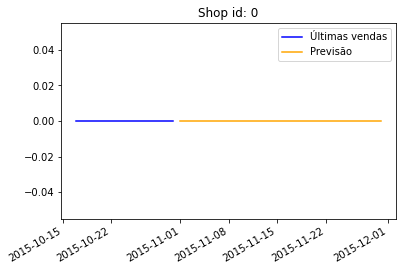

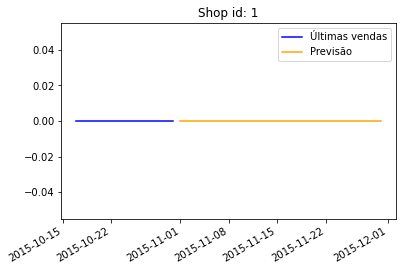

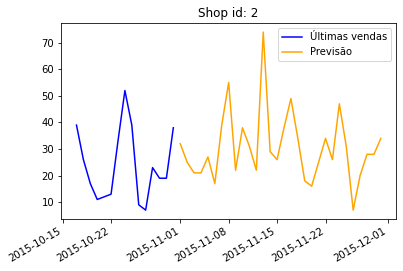

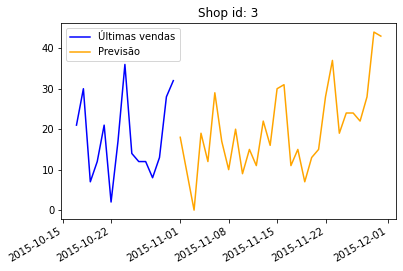

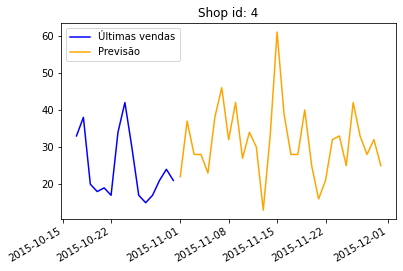

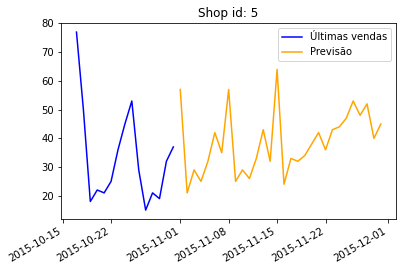

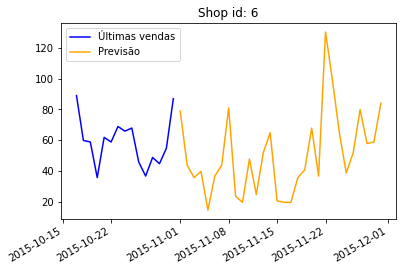

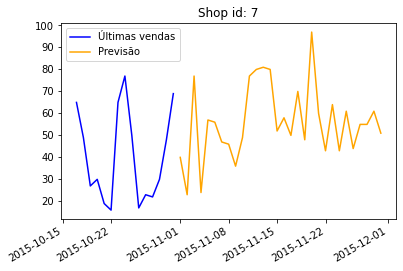

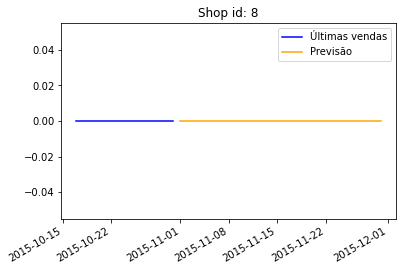

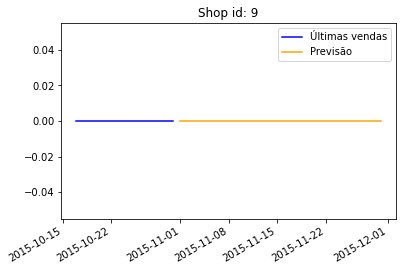

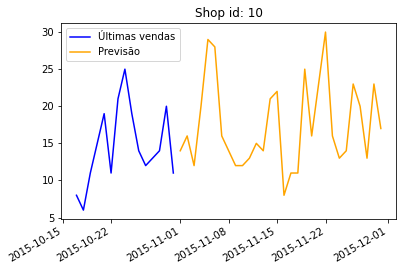

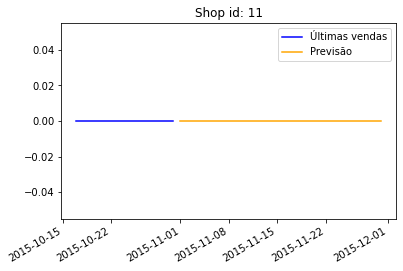

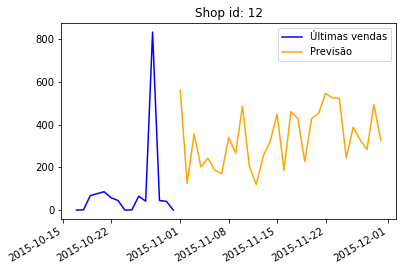

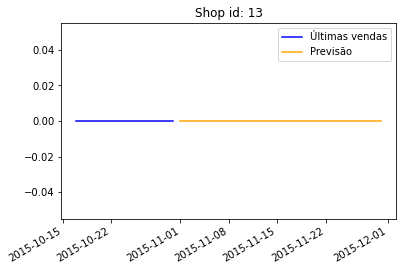

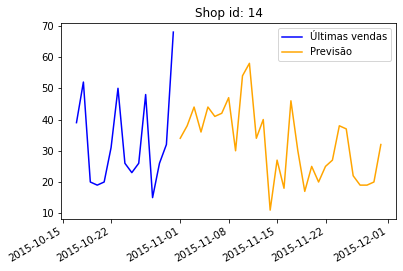

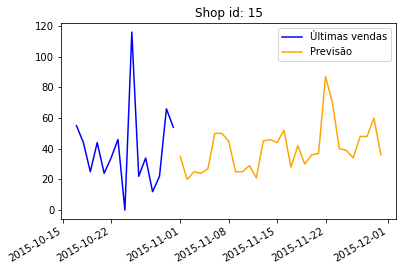

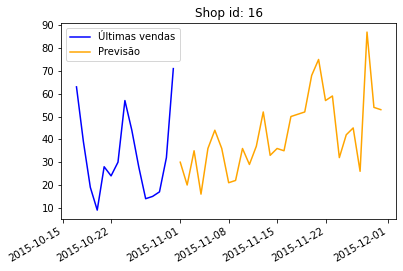

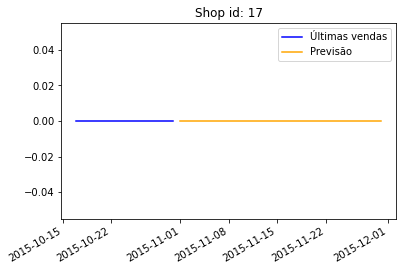

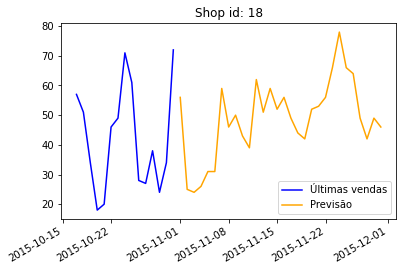

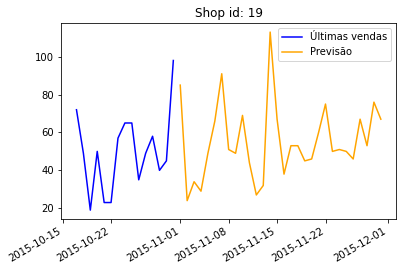

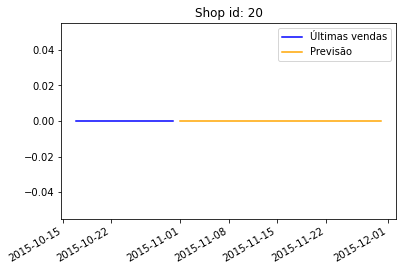

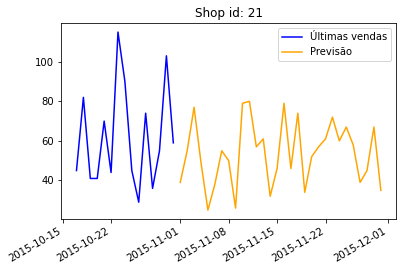

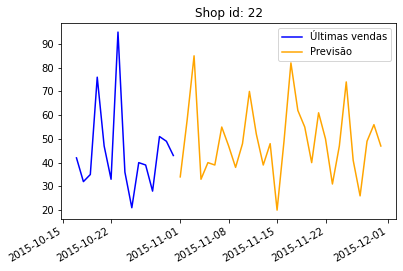

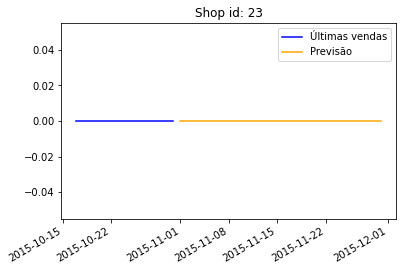

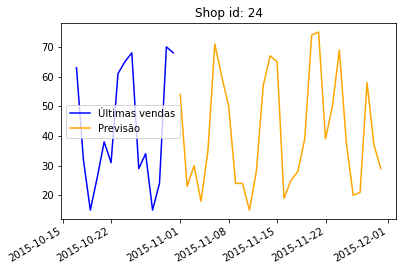

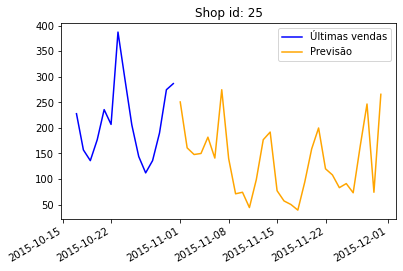

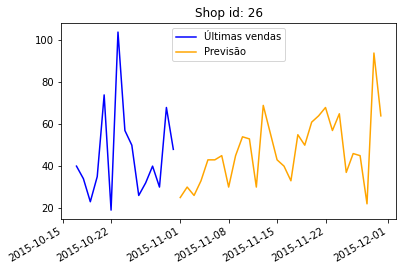

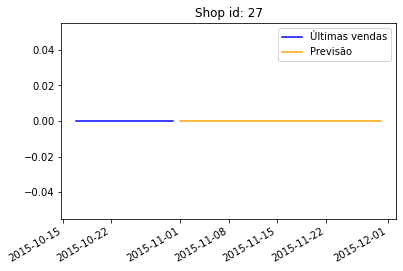

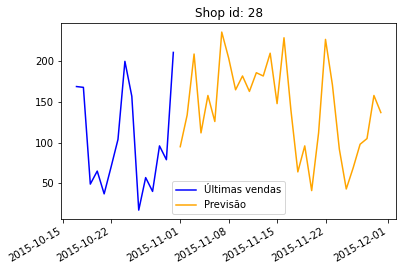

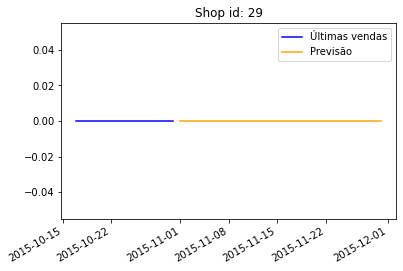

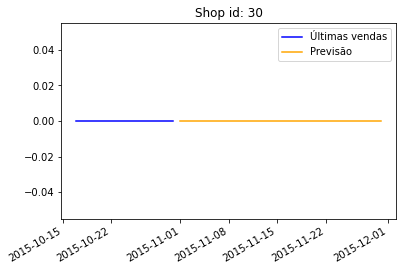

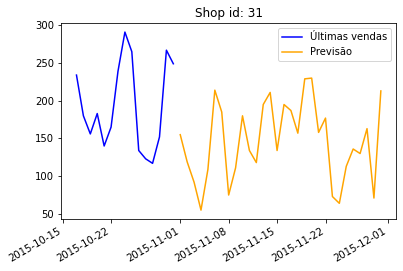

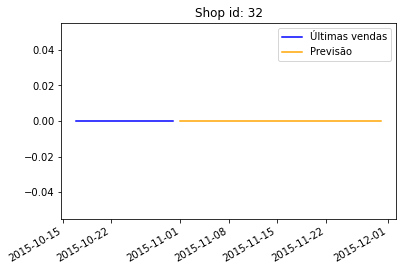

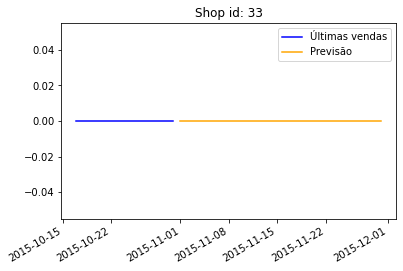

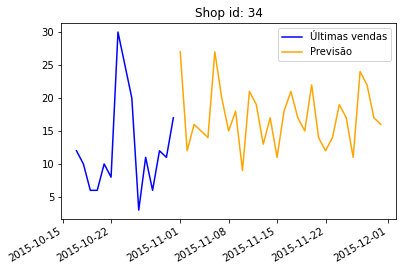

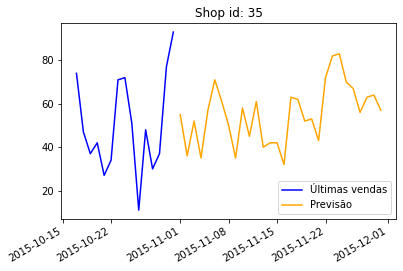

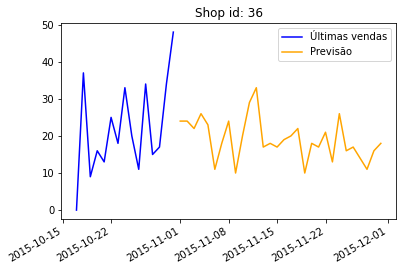

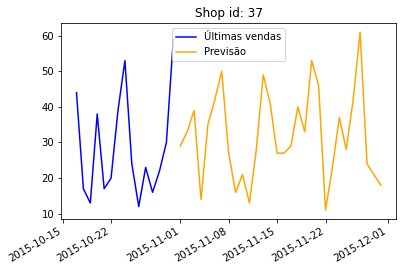

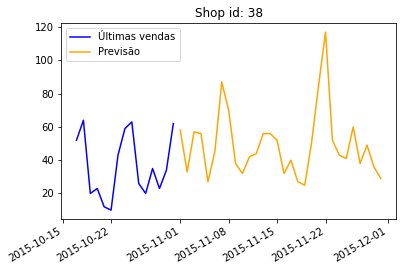

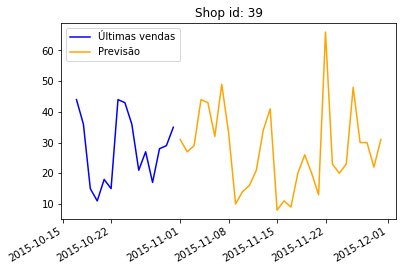

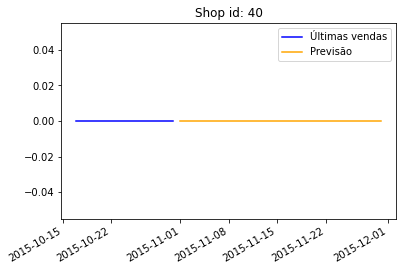

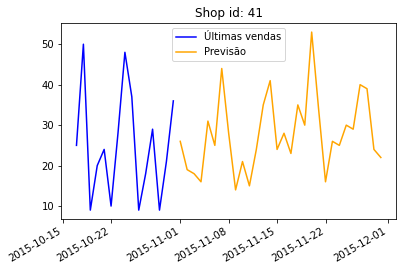

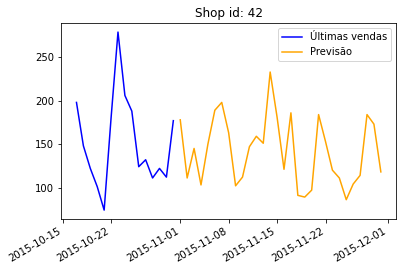

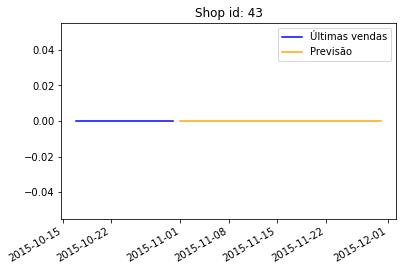

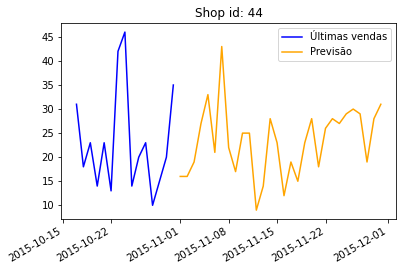

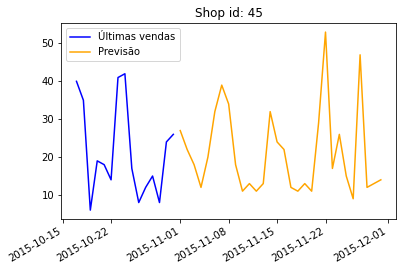

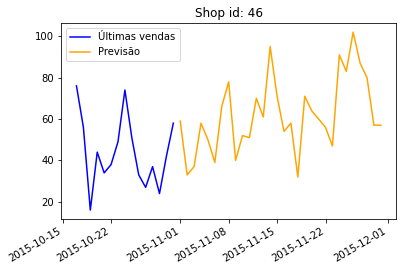

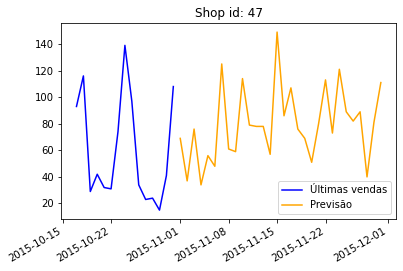

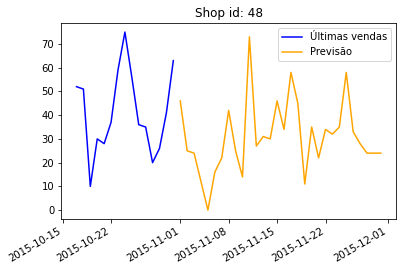

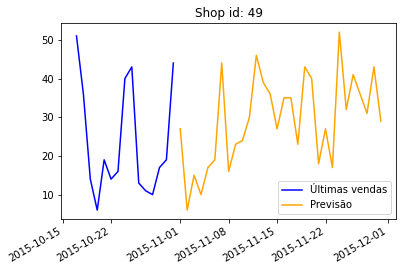

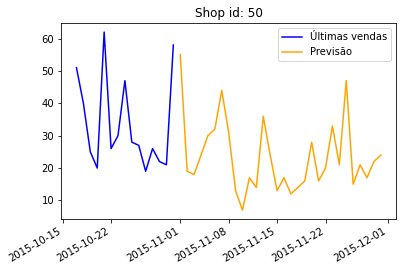

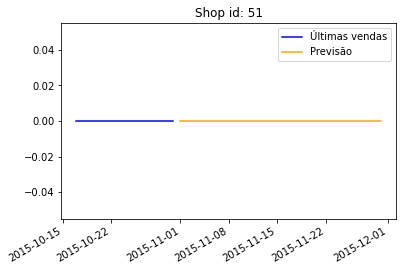

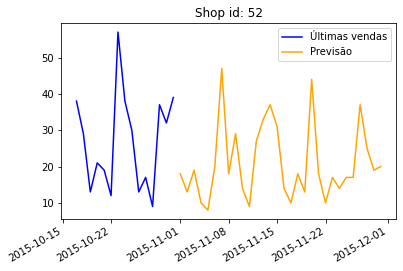

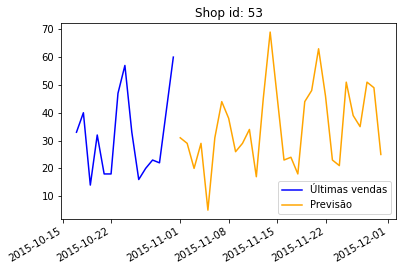

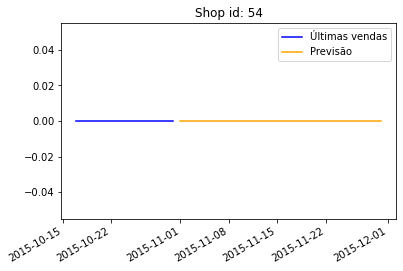

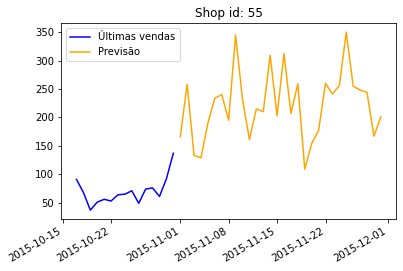

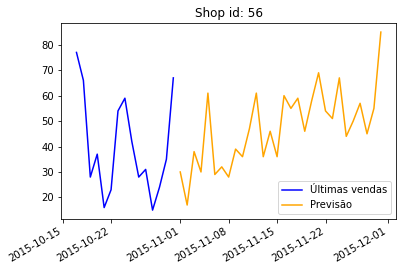

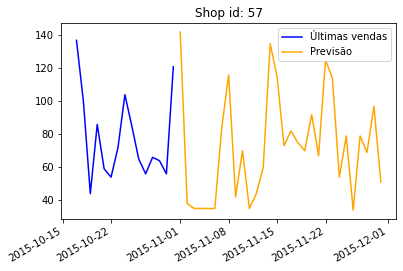

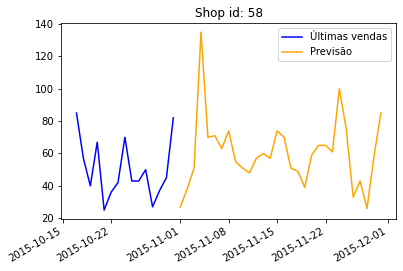

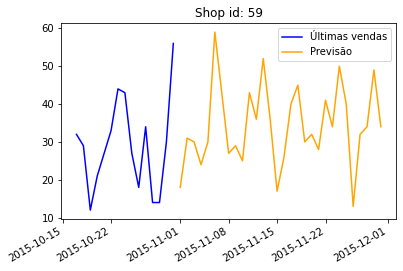

In [693]:
for n in range(60):
    fig, ax = plt.subplots(figsize=(6,4))
    plt.plot(test.fillna(0)[n].tail(15),color='blue',label='Últimas vendas')
    plt.plot(predictions[n],color='orange',label='Previsão')
    plt.title('Shop id: '+str(n))
    plt.legend()
    plt.xlabel('')
    #plt.xticks([])
    fig.autofmt_xdate()
    
    file_path = 'graphs//{}.png'
    plt.savefig(file_path.format(n),dpi=400)
    plt.show()

In [660]:
predictions.to_csv('predictions.csv',index=True,index_label='date')

## Result

    .Tempo de treinamento bom, tendo em vista que ele prevê para todas as lojas;
    .700 Epochs, MSE = 6.0242e-04
    .Em geral se ajustou bem em todas as lojas

# Section 2 - Telegram Bot

##### Bot name: forecast
##### Bot username: shops_forecastBot

## Imports

In [708]:
import os, telebot
from telegram import Update, ForceReply, Bot
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext
import requests

import pandas as pd
import matplotlib.pyplot as plt

import pygal
from pygal.style import DefaultStyle # PB

In [637]:
API_KEY = os.environ.get('FORECASTING_API_KEY')
bot = telebot.TeleBot(API_KEY)
'Shops_forecastBot'

'Shops_forecastBot'

In [638]:
shop_ids_list = [str(x) for x in range(60)]

@bot.message_handler(commands=shop_ids_list)
def shops(message):  
    file_path = 'graphs//{}.png'
    #try:
    shop_id = int(message.text[1:])
    total = predictions.iloc[:,shop_id].sum()
    
    bot.send_message(message.chat.id, "Previsão de {} itens vendidos para os próximos 30 dias.".format(total))
    bot.send_photo(message.chat.id, (open(file_path.format(shop_id),'rb') ), )
    #except:
        #bot.send_message(message.chat.id, "Foi nao")



In [639]:
bot.polling()